In [37]:
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csc_matrix
import numpy as np
from time import time

In [38]:
X_train, y_train = load_svmlight_file("data/rcv1_train")
X_test, y_test = load_svmlight_file("data/rcv1_test")
DATA_NAME = "rcv1"

In [39]:
from sklearn.svm import LinearSVC
m_ref = LinearSVC(C=1, tol=1e-12, fit_intercept=False, max_iter=5000, dual=False)
m_ref.fit(X_train, y_train)
m_ref.n_iter_

10

In [40]:
from Algorithm import CoordinateDescent
cd = CoordinateDescent(C=1., eps=1e-9)
w = cd.fit_process(X_train, y_train)

In [41]:
def clean_results(times, ws):
    # remove out of order observations, so no "travelling back in time" on plot
    # not ideal, but without setting things up properly it has to suffice
    times = np.array(times)
    ws = np.array(ws)
    bad_times = (times[1:] - times[:-1]) < 0
    while any(bad_times):
        times = np.concatenate(([times[0]], times[1:][~bad_times]))
        ws = np.concatenate(([ws[0]], ws[1:][~bad_times]))
        bad_times = (times[1:] - times[:-1]) < 0
    return times, ws

In [42]:
liblinear_primal_times = []
liblinear_primal_ws = []

for i in range(100):
    m = LinearSVC(C=1, tol=1e-9, max_iter=i, fit_intercept=False, dual=False)
    start_time = time()
    m.fit(X_train, y_train)
    time_used = time() - start_time
    if m.n_iter_ < i:
        break
    liblinear_primal_times.append(
        time_used
    )
    liblinear_primal_ws.append(
        m.coef_
    )
    
liblinear_primal_times, liblinear_primal_ws_cleaned = clean_results(liblinear_primal_times, liblinear_primal_ws)

In [43]:
from sklearn.svm import LinearSVC
import warnings
from time import time

warnings.filterwarnings("ignore") # intentional non-convergence

liblinear_times = []
liblinear_ws = []

for i in range(100):
    m = LinearSVC(C=1, tol=1e-9, max_iter=i, fit_intercept=False)
    start_time = time()
    m.fit(X_train, y_train)
    time_used = time() - start_time
    if m.n_iter_ < i:
        break
    liblinear_times.append(
        time_used
    )
    liblinear_ws.append(
        m.coef_
    )
    
liblinear_times, liblinear_ws_cleaned = clean_results(liblinear_times, liblinear_ws)

In [44]:
from sklearn.svm import SVC

libsvm_times = []
libsvm_ws = []
libsvm_samples = [i for i in range(0, 101, 5)]

for i in libsvm_samples:
    print(i, end="\r")
    m = SVC(kernel="linear", C=1, max_iter=i)
    start_time = time()
    m.fit(X_train, y_train)
    time_used = time() - start_time
    if m.n_iter_ < i:
        break
    libsvm_times.append(
        time_used
    )
    libsvm_ws.append(
        m.coef_.todense()
    )

libsvm_times, libsvm_ws_cleaned = clean_results(libsvm_times, libsvm_ws)

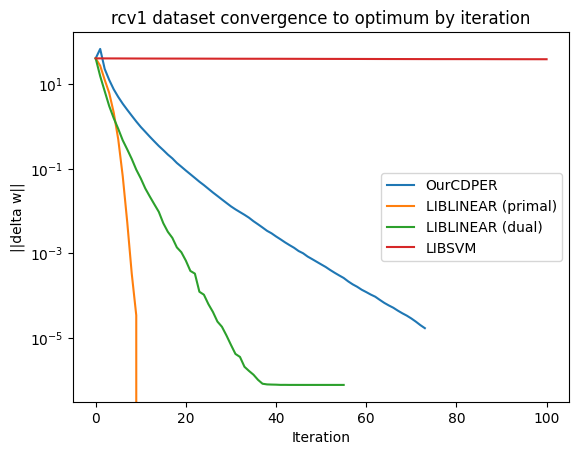

In [45]:
import matplotlib.pyplot as plt
plt.plot([
    np.linalg.norm(m_ref.coef_.reshape(-1)-el[0], ord=2) for el in cd.history
])
plt.plot([
    np.linalg.norm(m_ref.coef_.reshape(-1)-el.reshape(-1), ord=2) for el in liblinear_primal_ws
])
plt.plot([
    np.linalg.norm(m_ref.coef_.reshape(-1)-el.reshape(-1), ord=2) for el in liblinear_ws
])
plt.plot(libsvm_samples, [
    np.linalg.norm(m_ref.coef_.reshape(-1)-el.reshape(-1), ord=2) for el in libsvm_ws
])
plt.yscale("log")
plt.ylabel("||delta w||")
plt.legend(["OurCDPER", "LIBLINEAR (primal)", "LIBLINEAR (dual)", "LIBSVM"])
plt.title(f"{DATA_NAME} dataset convergence to optimum by iteration")
plt.xlabel("Iteration")
plt.show()

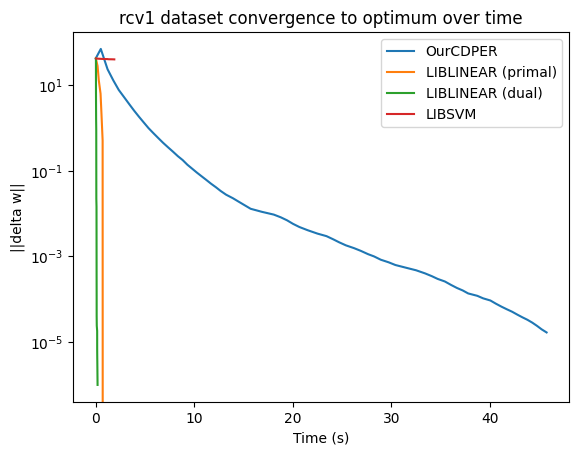

In [46]:
import matplotlib.pyplot as plt
plt.plot(np.array([el[2] for el in cd.history]) - cd.history[0][2], [
    np.linalg.norm(m_ref.coef_.reshape(-1)-el[0], ord=2) for el in cd.history
])
plt.plot(liblinear_primal_times, [
    np.linalg.norm(m_ref.coef_.reshape(-1)-el.reshape(-1), ord=2) for el in liblinear_primal_ws_cleaned
])
plt.plot(liblinear_times, [
    np.linalg.norm(m_ref.coef_.reshape(-1)-el.reshape(-1), ord=2) for el in liblinear_ws_cleaned
])
plt.plot(libsvm_times, [
    np.linalg.norm(m_ref.coef_.reshape(-1)-el.reshape(-1), ord=2) for el in libsvm_ws_cleaned
])
plt.yscale("log")
plt.ylabel("||delta w||")
plt.legend(["OurCDPER", "LIBLINEAR (primal)", "LIBLINEAR (dual)", "LIBSVM"])
plt.title(f"{DATA_NAME} dataset convergence to optimum over time")
plt.xlabel("Time (s)")
plt.show()

In [47]:
def accuracy_score_svm(w, X, y):
    return np.mean(((w @ X.T > 0) * 2 - 1) == y)

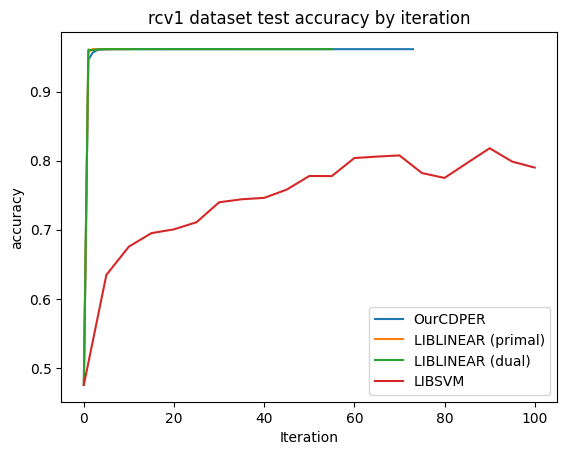

In [48]:
import matplotlib.pyplot as plt
plt.plot([
    accuracy_score_svm(el[0], X_test, y_test) for el in cd.history
])
plt.plot([
    accuracy_score_svm(el, X_test, y_test) for el in liblinear_primal_ws
])
plt.plot([
    accuracy_score_svm(el, X_test, y_test) for el in liblinear_ws
])
plt.plot(libsvm_samples, [
    accuracy_score_svm(el, X_test, y_test) for el in libsvm_ws
])
plt.ylabel("accuracy")
plt.legend(["OurCDPER", "LIBLINEAR (primal)", "LIBLINEAR (dual)", "LIBSVM"])
plt.title(f"{DATA_NAME} dataset test accuracy by iteration")
plt.xlabel("Iteration")
plt.show()

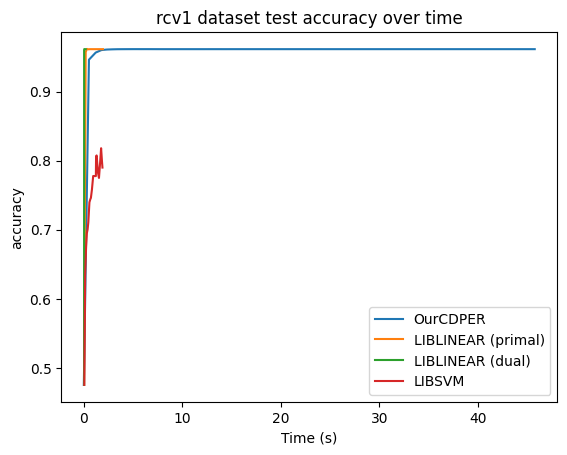

In [49]:
plt.plot(np.array([el[2] for el in cd.history]) - cd.history[0][2], [
    accuracy_score_svm(el[0], X_test, y_test) for el in cd.history
])
plt.plot(liblinear_primal_times, [
    accuracy_score_svm(el, X_test, y_test) for el in liblinear_primal_ws_cleaned
])
plt.plot(liblinear_times, [
    accuracy_score_svm(el, X_test, y_test) for el in liblinear_ws_cleaned
])
plt.plot(libsvm_times, [
    accuracy_score_svm(el, X_test, y_test) for el in libsvm_ws_cleaned
])
plt.ylabel("accuracy")
plt.legend(["OurCDPER", "LIBLINEAR (primal)", "LIBLINEAR (dual)", "LIBSVM"])
plt.title(f"{DATA_NAME} dataset test accuracy over time")
plt.xlabel("Time (s)")
plt.show()

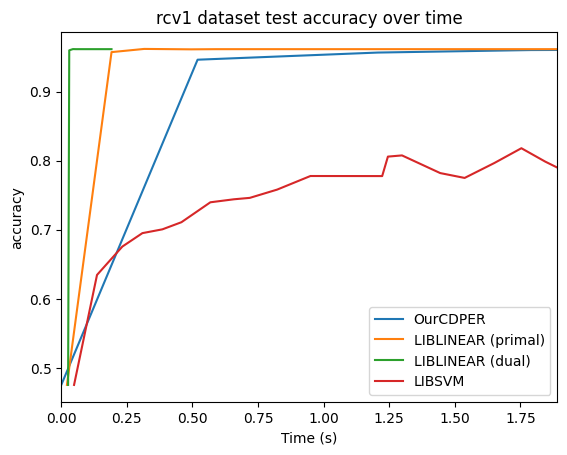

In [50]:
plt.plot(np.array([el[2] for el in cd.history]) - cd.history[0][2], [
    accuracy_score_svm(el[0], X_test, y_test) for el in cd.history
])
plt.plot(liblinear_primal_times, [
    accuracy_score_svm(el, X_test, y_test) for el in liblinear_primal_ws_cleaned
])
plt.plot(liblinear_times, [
    accuracy_score_svm(el, X_test, y_test) for el in liblinear_ws_cleaned
])
plt.plot(libsvm_times, [
    accuracy_score_svm(el, X_test, y_test) for el in libsvm_ws_cleaned
])
plt.ylabel("accuracy")
plt.legend(["OurCDPER", "LIBLINEAR (primal)", "LIBLINEAR (dual)", "LIBSVM"])
plt.title(f"{DATA_NAME} dataset test accuracy over time")
plt.xlabel("Time (s)")
plt.xlim(0, libsvm_times[-1])
plt.show()